In [1]:
# Code from Chapter 18 of Machine Learning: An Algorithmic Perspective (2nd Edition)
# by Stephen Marsland (http://stephenmonika.net)

# You are free to use, change, or redistribute the code in any way you wish for
# non-commercial purposes, but please maintain the name of the original author.
# This code comes with no warranty of any kind.

# Stephen Marsland, 2014
%matplotlib inline
import matplotlib.pyplot as pl
import numpy as np
import scipy.optimize as so
import seaborn
from scipy.stats import multivariate_normal
seaborn.set_context("paper",font_scale=2)
seaborn.set_style("whitegrid")


In [2]:
def kernel2(data1,data2,theta,wantderiv=True,measnoise=1.):
    # Uses exp(theta) to ensure positive hyperparams
    theta = np.squeeze(theta)
 
    theta = np.exp(theta)
    # Squared exponential
    if np.ndim(data1) == 1:
        d1 = np.shape(data1)[0]
        n = 1
        data1 = data1*np.ones((d1,1))
        data2 = data2*np.ones((np.shape(data2)[0],1))
    else:
        (d1,n) = np.shape(data1)

    d2 = np.shape(data2)[0]
    sumxy = np.zeros((d1,d2))
    for d in range(n):
        D1 = np.transpose([data1[d]]) * np.ones((d1,d2))
        D2 = [data2[d]] * np.ones((d1,d2))
        #print theta[d+1]
        sumxy += ((D1-D2)**2)*theta[d+1]


    k = theta[0] * np.exp(-0.5*sumxy) 
    #k = theta[0]**2 * np.exp(-sumxy/(2.0*theta[1]**2))

    #print k
    #print measnoise*theta[2]**2*np.eye(d1,d2)
    if wantderiv:
        K = np.zeros((d1,d2,len(theta)+1))
        # K[:,:,0] is the original covariance matrix
        K[:,:,0] = k + measnoise*theta[2]*np.eye(d1,d2)
        K[:,:,1] = k
        K[:,:,2] = -0.5*k*sumxy
        K[:,:,3] = theta[2]*np.eye(d1,d2)
        return K
    else:
        return k + measnoise*theta[2]*np.eye(d1,d2)

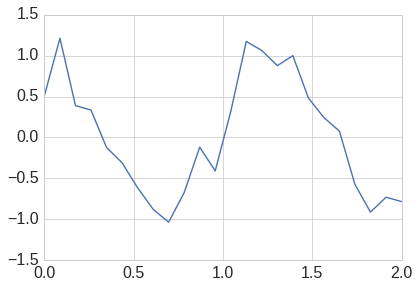

In [3]:
X = np.linspace(0,10,num=4)
x = np.linspace(0,40,num=24)

#tt = np.concatenate([np.cos(x/4),np.sin(4*X)])
tt = np.cos(x/4)
#tt  =  np.hstack([np.zeros(50),np.ones(50)*8]) - 3 + np.random.normal(scale=2,size=100)

t = tt + np.random.normal(scale=.3,size=len(tt))
x = np.linspace(0,2,num=len(t))

pl.plot(x,t)
theta = np.array([1e0,0,.05])
K = kernel2(data1=x,data2=x,theta=theta)
#pl.imshow(K[:,:,1],cmap='RdBu')
#pl.grid()
#pl.colorbar()

In [4]:
def predict(xstar,data,k,t,theta,L=None,beta=None):
    if L==None:
        L = np.linalg.cholesky(k)
        beta = np.linalg.solve(L.transpose(), np.linalg.solve(L,t))
    kstar = kernel2(data,xstar,theta,wantderiv=False,measnoise=0)
    f = np.dot(kstar.transpose(), beta)
    v = np.linalg.solve(L,kstar)
    V = kernel2(xstar,xstar,theta,wantderiv=False,measnoise=0)-np.dot(v.transpose(),v)
    #logp = -0.5*np.dot(t.transpose(),beta) - np.sum(np.log(np.diag(L))) - np.shape(data)[0] /2. * np.log(2*np.pi)
    return (f,V)


In [5]:
def logPosterior(theta,data,t):
    #data,t = args
    k = kernel2(data,data,theta,wantderiv=False)
    L = np.linalg.cholesky(k)
    beta = np.linalg.solve(L.transpose(), np.linalg.solve(L,t))
    logp = -0.5*np.dot(t.transpose(),beta) - np.sum(np.log(np.diag(L))) - \
           np.shape(data)[0] /2. * np.log(2*np.pi)
    #print t
    return -logp


In [6]:
def gradLogPosterior(theta,data,t):
    #data,t = args
    theta = np.squeeze(theta)
    d = len(theta)
    K = kernel2(data,data,theta,wantderiv=True)

    L = np.linalg.cholesky(np.squeeze(K[:,:,0]))
    invk = np.linalg.solve(L.transpose(),np.linalg.solve(L,np.eye(np.shape(data)[0])))
    # P404, Eqn 18.12
    dlogpdtheta = np.zeros(d)
    for d in range(1,len(theta)+1):
        dlogpdtheta[d-1] = 0.5*np.dot(t.transpose(), np.dot(invk, np.dot(np.squeeze(K[:,:,d]),
                            np.dot(invk,t)))) - 0.5*np.trace(np.dot(invk,np.squeeze(K[:,:,d])))
    #print t
    return -dlogpdtheta


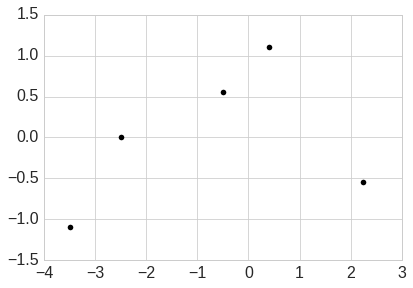

In [7]:
x = np.array([-3.5, -2.5, -.5, .4, 2.25])
t = 0.55*np.array([-2., 0., 1., 2., -1.])
pl.plot(x,t,'ko')

In [8]:
import scipy.optimize as op

theta = np.array([ 2., 1.01591201, -1.8305131]) # GP4

print theta, -logPosterior(theta,x,t)
r = op.minimize(fun = logPosterior,
                x0 = theta,
                args = (x,t),
                jac=gradLogPosterior,
                method='CG',
                options = {'disp': 1,'gtol':1e-6,})
newTheta = r.x
print newTheta, -logPosterior(newTheta,x,t)

[ 2.          1.01591201 -1.8305131 ] -9.75214530453
Optimization terminated successfully.
         Current function value: 5.591303
         Iterations: 65
         Function evaluations: 154
         Gradient evaluations: 154
[ -0.54350338   0.80947788 -14.78842393] -5.59130280408


In [9]:
args = (x,t)
print theta, -logPosterior(theta,x,t)
newTheta = so.fmin_cg(logPosterior,
                      newTheta,
                      fprime=gradLogPosterior,
                      args=(x,t),
                      gtol=1e-8,maxiter=500)
print newTheta, -logPosterior(newTheta,x,t)

[ 2.          1.01591201 -1.8305131 ] -9.75214530453
Optimization terminated successfully.
         Current function value: 5.591303
         Iterations: 22
         Function evaluations: 42
         Gradient evaluations: 42
[ -0.54350264   0.80947793 -18.5901587 ] -5.59130273857


In [10]:
x.max()

2.25

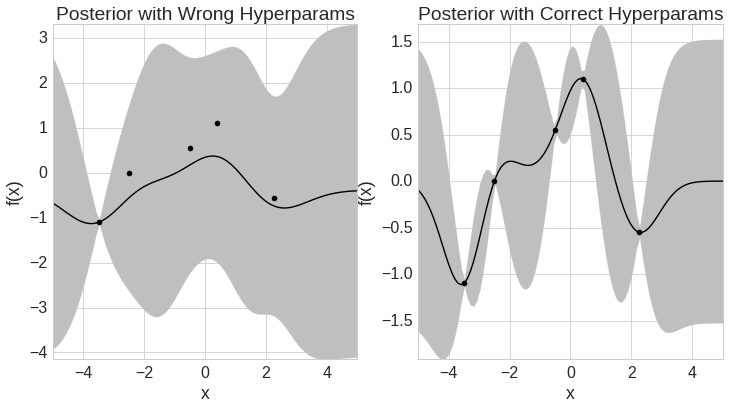

In [13]:
xstar = np.linspace(-5,5,100)
theta2 = np.array([1,1e-2,.1]) # GP4
theta = newTheta

ts = [theta2,newTheta]
pl.figure(figsize=(12,6))
for i in range(2):
    
    theta = ts[i]
    
    k = kernel2(x,x,theta,wantderiv=False)
    kstar = [kernel2(x,xs*np.ones((1,1)),theta,wantderiv=False) for xs in xstar]
    kstar = np.squeeze(kstar)
    kstarstar = [kernel2(xs*np.ones((1,1)),xs*np.ones((1,1)),theta,wantderiv=False) for xs in xstar]
    kstarstar = np.squeeze(kstarstar)
    #kstarstar = kernel2(xstar,xstar,theta,wantderiv=False)

    L = np.linalg.cholesky(k)
    invk = np.linalg.solve(L.transpose(),np.linalg.solve(L,np.eye(np.shape(x)[0])))
    #invL = np.linalg.inv(L)
    #invk = np.dot(invL.T,invL)
    mean = np.dot(kstar,np.dot(invk,t))
    #print np.shape(kstarstar), np.shape(kstar), np.shape(invk)
    var = kstarstar - np.diag(np.dot(kstar,np.dot(invk,kstar.T)))
    #print np.shape(var)
    #var = kstarstar - np.dot(kstar.transpose(),np.dot(invk,kstar))
    #var = np.reshape(var,(100,1))
    #print mean

    pl.subplot(1,2,1+i)
    pl.title('Posterior with %s Hyperparameters' %['Wrong','Correct'][i])
    pl.plot(xstar,mean,'-k')
    #pl.plot(xstar,mean+2*np.sqrt(var),'x-')
    #pl.plot(xstar,mean-2*np.sqrt(var),'x-')
    #print np.shape(xstar), np.shape(mean), np.shape(var)
    pl.fill_between(np.squeeze(xstar),np.squeeze(mean-2*np.sqrt(var)),
                    np.squeeze(mean+2*np.sqrt(var)),color='0.75')
    pl.plot(x,t,'ko')
    #pl.plot(x,tt,color=[.8,.2,.2],linestyle='--',linewidth=3)
    pl.axis('tight')
    pl.xlabel('x')
    pl.ylabel('f(x)')

In [738]:
def testopt():
    theta = np.array([0.5,0.25,0.1]) # GP4

    x = np.array([[-3.5, -2.5, -.5, .4, 2.25]]).transpose()
    t = 0.55*np.array([[-2., 0., 1., 2., -1.]]).transpose()

    args = (x,t)
    print theta, -logPosterior(theta,args)
    newTheta = so.fmin_cg(logPosterior, theta, fprime=gradLogPosterior, args=[args],
                          gtol=1e-4,maxiter=50,disp=1)
    print newTheta, -logPosterior(newTheta,args)
    #theta = newTheta

    xstar = np.reshape(np.linspace(-5,5,100),(100,1))

    k = kernel2(x,x,theta,wantderiv=False)
    kstar = [kernel2(x,xs*np.ones((1,1)),theta,wantderiv=False) for xs in xstar]
    kstar = np.squeeze(kstar)
    kstarstar = [kernel2(xs*np.ones((1,1)),xs*np.ones((1,1)),theta,wantderiv=False) for xs in xstar]
    kstarstar = np.squeeze(kstarstar)
    #kstarstar = kernel2(xstar,xstar,theta,wantderiv=False)

    L = np.linalg.cholesky(k)
    invk = np.linalg.solve(L.transpose(),np.linalg.solve(L,np.eye(np.shape(x)[0])))
    #invL = np.linalg.inv(L)
    #invk = np.dot(invL.T,invL)
    mean = np.dot(kstar,np.dot(invk,t))
    #print np.shape(kstarstar), np.shape(kstar), np.shape(invk)
    var = kstarstar - np.diag(np.dot(kstar,np.dot(invk,kstar.T)))
    #print np.shape(var)
    #var = kstarstar - np.dot(kstar.transpose(),np.dot(invk,kstar))
    var = np.reshape(var,(100,1))
    #print mean

    pl.figure()
    pl.plot(xstar,mean,'-k')
    #pl.plot(xstar,mean+2*np.sqrt(var),'x-')
    #pl.plot(xstar,mean-2*np.sqrt(var),'x-')
    #print np.shape(xstar), np.shape(mean), np.shape(var)
    pl.fill_between(np.squeeze(xstar),np.squeeze(mean-2*np.sqrt(var)),
                    np.squeeze(mean+2*np.sqrt(var)),color='0.75')
    pl.plot(x,t,'ko')
    pl.axis('tight')
    pl.xlabel('x')
    pl.ylabel('f(x)')



In [132]:
testopt()

[ 0.5   0.25  0.1 ] 1.28402541669
[[-7.28088204]]


TypeError: can only concatenate tuple (not "list") to tuple

In [131]:
def demoplot(theta,args):
    colour=np.array([0,0,1.0])
    faded = 1-(1-colour)/2.0

    (X,y) = args
    (n, D) = np.shape(X)

    xrange = X.max() - X.min()
    Xtest = np.arange(X.min()-xrange/2,X.max()+xrange/2,(X.max()-X.min())/100)
    Xtest.shape = (len(Xtest),1)

    k = kernel2(X,X,theta,wantderiv=False)
    kstar = [kernel2(X,xs*np.ones((1,1)),theta,wantderiv=False,measnoise=False) for xs in Xtest]
    kstar = np.squeeze(kstar)
    kstarstar = [kernel2(xs*np.ones((1,1)),xs*np.ones((1,1)),theta,wantderiv=False,measnoise=False) for xs in Xtest]
    kstarstar = np.squeeze(kstarstar)

    L = np.linalg.cholesky(k)
    invk = np.linalg.solve(L.transpose(),np.linalg.solve(L,np.eye(np.shape(X)[0])))
    mean = np.dot(kstar,np.dot(invk,y))
    var = kstarstar - np.diag(np.dot(kstar,np.dot(invk,kstar.T)))
    #var = np.reshape(var,(100,1))

    pl.ion()
    fig = pl.figure()
    #ax1 = fig.add_subplot(211)
    #ax2 = fig.add_subplot(212,sharex=ax1,sharey=ax1)
    pl.plot(Xtest,mean,'-k')
    #pl.plot(xstar,mean+2*np.sqrt(var),'x-')
    #pl.plot(xstar,mean-2*np.sqrt(var),'x-')
    #print np.shape(xstar), np.shape(mean), np.shape(var)
    pl.fill_between(np.squeeze(Xtest),np.squeeze(mean-2*np.sqrt(var)),np.squeeze(mean+2*np.sqrt(var)),color='0.75')
    pl.plot(X,y,'ko')
#pl.axis('tight')
#pl.xlabel('x')
#pl.ylabel('f(x)')

#covariance = np.exp(theta[0])*np.exp(-np.exp(theta[1])*Xtest**2)
#print np.shape(Xtest), np.shape(covariance)
#ax2.fill_between(np.squeeze(Xtest),np.squeeze(np.zeros(np.shape(Xtest))),np.squeeze(covariance),color='black',alpha=.2)
#ax2.plot(0,np.exp(theta[0]) + np.exp(theta[-1]),'o',color='black')


In [130]:

def showpost():
    #theta = np.array([0.5,1.,0.0]) # GP1
    #theta = np.array([0.5,1.,0.2]) # GP2
    #theta = np.array([1.0,1.,0.0]) # GP3
    theta = np.array([0.5,0.5,0.0]) # GP4

    x = np.array([[-3.5, -2.5, -.5, .4, 2.25]]).transpose()
    t = 0.55*np.array([[-2., 0., 1., 2., -1.]]).transpose()
    xstar = np.reshape(np.linspace(-5,5,100),(100,1))

    k = kernel2(x,x,theta,wantderiv=False)
    kstar = [kernel2(x,xs*np.ones((1,1)),theta,wantderiv=False) for xs in xstar]
    kstar = np.squeeze(kstar)
    kstarstar = [kernel2(xs*np.ones((1,1)),xs*np.ones((1,1)),theta,wantderiv=False) for xs in xstar]
    kstarstar = np.squeeze(kstarstar)
    #kstarstar = kernel(xstar,xstar,theta,wantderiv=False)

    #invk = np.linalg.inv(k)
    L = np.linalg.cholesky(k)
    invk = np.linalg.solve(L.transpose(),np.linalg.solve(L,np.eye(np.shape(x)[0])))
    mean = np.dot(kstar,np.dot(invk,t))
    var = kstarstar - np.diag(np.dot(kstar,np.dot(invk,kstar.T)))
    var = np.reshape(var,(100,1))

    pl.figure()
    pl.plot(xstar,mean,'-k')
    #pl.plot(xstar,mean+2*np.sqrt(var),'x-')
    #pl.plot(xstar,mean-2*np.sqrt(var),'x-')
    #print np.shape(xstar), np.shape(mean), np.shape(var)
    pl.fill_between(np.squeeze(xstar),np.squeeze(mean-2*np.sqrt(var)),
                    np.squeeze(mean+2*np.sqrt(var)),color='0.75')
    pl.plot(x,t,'ko')
    pl.axis('tight')
    pl.xlabel('x')
    pl.ylabel('f(x)')

    print np.shape(mean), np.shape(var)

def showlength(theta,scale):

    x = scale*np.array([[-3.5, -2.5, -.5, .4, 2.25]]).transpose()
    t = 0.55*np.array([[-2., 0, 1., 2., -1.]]).transpose()
    xstar = np.reshape(np.linspace(-5,5,100),(100,1))

    k = kernel2(x,x,theta,wantderiv=False)
    print k
    #print k
    kstar = [kernel2(x,xs*np.ones((1,1)),theta,wantderiv=False,measnoise=False) for xs in xstar]
    kstar = np.squeeze(kstar)
    #print kstar
    kstarstar = [kernel2(xs*np.ones((1,1)),xs*np.ones((1,1)),theta,wantderiv=False,measnoise=False) for xs in xstar]
    kstarstar = np.squeeze(kstarstar)
    #kstarstar = kernel2(xstar,xstar,theta,wantderiv=False)

    L = np.linalg.cholesky(k)
    #invL = np.linalg.inv(L)
    #invk = np.dot(invL.T,invL)
    invk = np.linalg.solve(L.transpose(),np.linalg.solve(L,np.eye(np.shape(x)[0])))
    #print np.shape(kstar), np.shape(invk), np.shape(t), np.shape(kstarstar), np.shape(np.dot(kstar,np.dot(invk,kstar.T)))
    mean = np.dot(kstar,np.dot(invk,t))
    var = kstarstar - np.diag(np.dot(kstar,np.dot(invk,kstar.T)))
    var = np.reshape(var,(100,1))

    pl.ion()
    pl.figure()
    pl.plot(xstar,mean,'-k')
    #pl.plot(xstar,mean+2*np.sqrt(var),'x-')
    #pl.plot(xstar,mean-2*np.sqrt(var),'x-')
    #print np.shape(xstar), np.shape(mean), np.shape(var)
    pl.fill_between(np.squeeze(xstar),np.squeeze(mean-2*np.sqrt(var)),np.squeeze(mean+2*np.sqrt(var)),color='0.75')
    pl.plot(x,t,'ko')
    pl.axis('tight')
    pl.xlabel('x')
    pl.ylabel('f(x)')

def runlength():
    theta1 = np.array([0.5,1.,0.0])
    theta2 = np.array([0.5,0.5,0.0])
    showlength(theta1,1.)
    showlength(theta2,1.)
    showlength(theta1,.5)
    showlength(theta2,.5)

def runhp():
    theta1 = np.array([0.5,1.0,0.0])
    theta2 = np.array([0.5,1.0,0.2])
    theta3 = np.array([0.5,1.0,0.4])
    theta8 = np.array([0.5,1.0,0.6])
    theta4 = np.array([0.25,1.0,0.0])
    theta5 = np.array([1.0,1.0,0.0])
    theta6 = np.array([0.5,0.5,0.0])
    theta7 = np.array([0.5,2.0,0.0])
    showlength(theta1,1.)
    showlength(theta2,1.)
    showlength(theta3,1.)
    showlength(theta4,1.)
    showlength(theta5,1.)
    showlength(theta6,1.)
    showlength(theta7,1.)
    showlength(theta8,1.)

    data = np.loadtxt("data.txt")
    X = data[:,0:-1] # everything except the last column
    y = data[:,-1]   # just the last column

    args = (X,y)

    #theta = np.array([ 1.7657065779589087, -1.3841332550882446, -10.162222605402242])
    #theta = np.array([ 1.7999382115210827, -14.001391904643032 , -5.577578503745549])
    theta = np.zeros(3)
    theta[0] = np.random.normal(0,5)
    theta[1] = np.random.normal(0,5)
    theta[2] = np.random.normal(0,5)
    print theta
    print np.exp(theta)
    print logPosterior(theta,args)
    print gradLogPosterior(theta,args)
    print so.check_grad(logPosterior, gradLogPosterior, theta, args)

    newTheta = so.fmin_cg(logPosterior, theta, fprime=gradLogPosterior, args=args, gtol=1e-4,maxiter=100,disp=1)
    print newTheta, logPosterior(newTheta,args)

    K = kernel2(X,X,newTheta,wantderiv=False)
    L = np.linalg.cholesky(K)
    beta = np.linalg.solve(L.transpose(), np.linalg.solve(L,y))
    test = X
    #pred = [predict(i,input,K,target,newTheta,L,beta) for i in input]
    #pred = np.squeeze([predict(i,input,K,target,newTheta,L,beta) for i in input])
    demoplot(theta,args)
    demoplot(newTheta,args)

